# Procesar el dataset de pruebas

Este dataset está obtenido de [Kaggle](https://www.kaggle.com/jruvika/fake-news-detection). Contiene los titulares y cuerpos de las noticias, que son de dos posibles tipos de categorías. "Falsa (0)" y "True (1)". 

In [16]:
import pandas as pd

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
import swifter

from matplotlib import pyplot as plt
from matplotlib import style

#Nicer style
style.use('seaborn') 

import re #regexp
from nltk.tokenize import RegexpTokenizer

#word2vec
from gensim.models import KeyedVectors

Constantes necesarias

In [17]:
PATH_DATASET = "../data/Other_datasets/fake-news-detection/data.csv"
PATH_PROCESSED = "../data/Other_datasets/fake-news-detection/data_kaggle_proc.pickle"

#Padding number for title and content
MAX_LEN_TITLE = 13
MAX_LEN_CONTENT = 1598

#Convert labels
LBL_TRUE = [0,0,0,1]
LBL_FAKE = [0,0,1,0]

In [18]:
df = pd.read_csv(PATH_DATASET).dropna()[['Headline', 'Body', 'Label']]

In [19]:
df.head()

,Headline,Body,Label
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


Número de noticias. por tipo en el dataset.

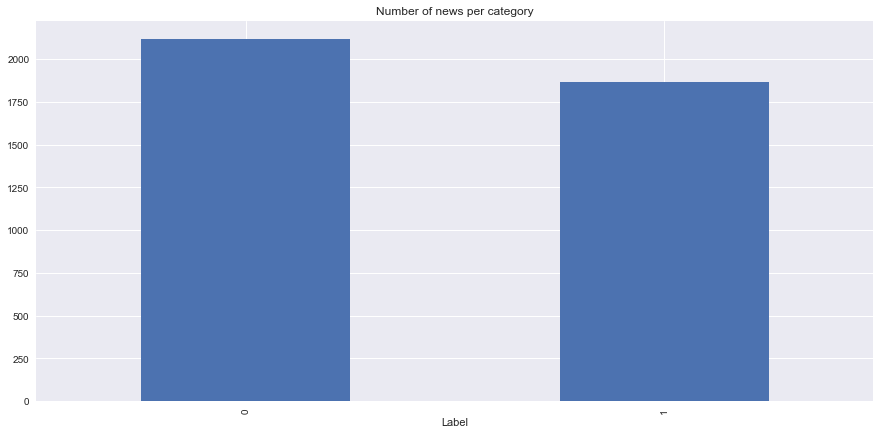

In [20]:
plt.figure(figsize=(15,7))
df.groupby('Label').count()['Headline'].plot.bar(title="Number of news per category")

Procesamos el dataset

In [21]:
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

In [22]:
def pad_array(array, token_len):
    diff_token = token_len - len(array)
    if(diff_token < 0):
        array = array[:token_len] #Truncate
    else:
        #Pad
        array += [0]*diff_token #Pad
        
    return array  

In [23]:
#Clean content
df['Body'] = df.swifter.apply(lambda row: clean_text(row['Body']), axis=1)
#Clean title
df['Headline'] = df.swifter.apply(lambda row: clean_text(row['Headline']), axis=1)

Pandas Apply: 100%|██████████| 3988/3988 [00:00<00:00, 34533.49it/s]


Convertir a los indices de **word2vec**

In [24]:
model = KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin.gz", binary=True,
                                          limit=50000)

In [25]:
df['Headline'] = df.swifter.apply(lambda r: 
                        [model.vocab[x].index for x in r['Headline'] if x in model.vocab], axis=1)
df['Body'] = df.swifter.apply(lambda r: 
                        [model.vocab[x].index for x in r['Body'] if x in model.vocab], axis=1)


#Drop news with short or no title
df = df[df['Headline'].map(len) >= 1]
#Reset index
df = df.reset_index().drop("index", axis=1)

Pandas Apply: 100%|██████████| 3988/3988 [00:00<00:00, 6349.86it/s]


Distribución para el cuerpo de los artículos.

Pandas Apply: 100%|██████████| 3980/3980 [00:00<00:00, 49281.68it/s]


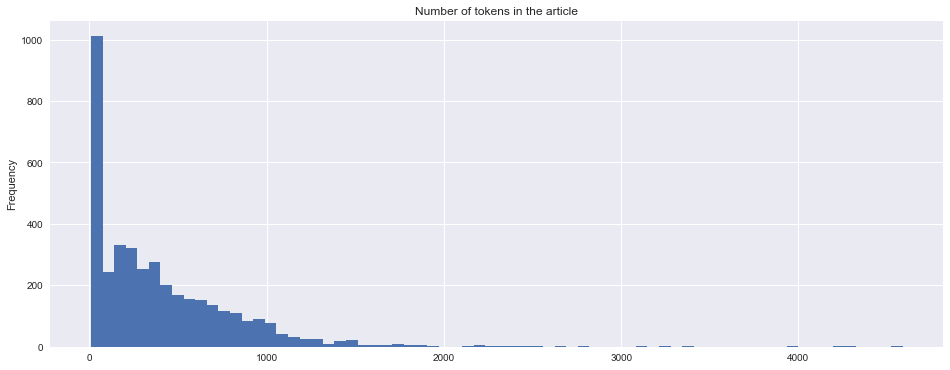

In [26]:
# Longitud en tokens de cada noticia
tokens_numbers = df.swifter.apply(lambda row: len(row['Body']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 70, ax=ax)

In [15]:
print("Número medio de tokens por artículo: {}".format(int(np.mean(tokens_numbers))))
print("Desviación estándar de tokens por artículo: {}".format(int(np.std(tokens_numbers))))
print("Mediana de tokens por artículo: {}".format(int(np.median(tokens_numbers))))

max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Ventana de tokens escogida: {} - Cubre el {}% del dataset".format(max_tokens, percent_tokens*100))

Número medio de tokens por artículo: 404
Desviación estándar de tokens por artículo: 424
Mediana de tokens por artículo: 289
Ventana de tokens escogida: 1254 - Cubre el 96.20603015075378% del dataset


Para los títulos

Número medio de tokens por título: 7
Desviación estándar de tokens por título: 3
Mediana de tokens por título: 8
Ventana de tokens escogida: 13 - Cubre el 97.9145728643216% del dataset


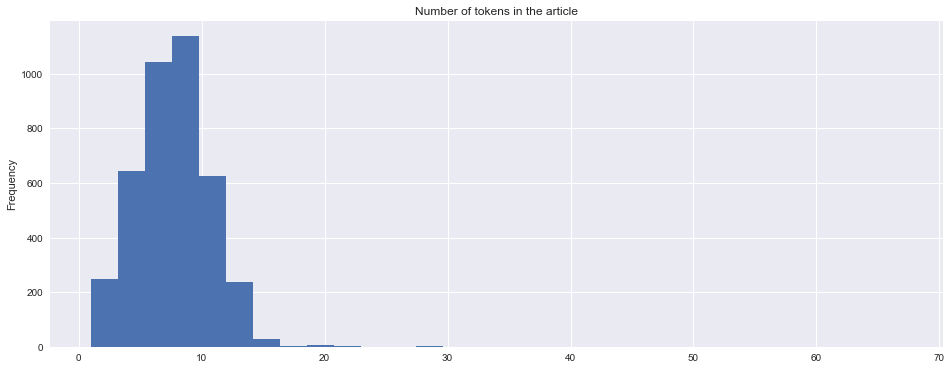

In [28]:
# Longitud en tokens de cada noticia
tokens_numbers = df.apply(lambda row: len(row['Headline']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 30, ax=ax)

print("Número medio de tokens por título: {}".format(int(np.mean(tokens_numbers))))
print("Desviación estándar de tokens por título: {}".format(int(np.std(tokens_numbers))))
print("Mediana de tokens por título: {}".format(int(np.median(tokens_numbers))))

max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

n_tokens = max_tokens

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Ventana de tokens escogida: {} - Cubre el {}% del dataset".format(max_tokens, percent_tokens*100))


In [11]:
df['Headline'] = df.apply(lambda r: pad_array(r['Headline'], MAX_LEN_TITLE) , axis=1)
df['Body'] = df.apply(lambda r: pad_array(r['Body'], MAX_LEN_CONTENT) , axis=1)

Convertir label

In [12]:
df.loc[df['Label'] == 1, 'Label'] = pd.Series([LBL_TRUE] * len(df))
df.loc[df['Label'] == 0, 'Label'] = pd.Series([LBL_FAKE] * len(df))
#loc[df1['stream'] == 2, 'feat'] = 10

In [13]:
df.head()

,Headline,Body,Label
0,"[2675, 1143, 2205, 48926, 6117, 13034, 0, 0, 0...","[15680, 8429, 28683, 14257, 312, 281, 565, 611...","[0, 0, 0, 1]"
1,"[556, 2168, 3912, 5042, 2360, 508, 115, 948, 0...","[4949, 20876, 17535, 3912, 46, 3610, 556, 3230...","[0, 0, 0, 1]"
2,"[13034, 12828, 316, 48926, 553, 16854, 23325, ...","[7, 14446, 1506, 69, 208, 995, 64, 116, 61, 60...","[0, 0, 0, 1]"
3,"[2905, 1469, 1930, 8, 44732, 2, 3538, 19568, 4...","[29922, 2905, 6585, 4840, 301, 11, 1080, 1428,...","[0, 0, 0, 1]"
4,"[2678, 3466, 8, 11440, 5739, 0, 0, 0, 0, 0, 0,...","[4868, 3076, 2678, 31, 10, 3246, 14, 11, 11440...","[0, 0, 0, 1]"


In [14]:
df.to_pickle(PATH_PROCESSED)